In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pandas as pd

In [ ]:
tfds.disable_progress_bar()
train,valid,test=tfds.load('rock_paper_scissors',split=['train','test[:50%]','test[:50%]'],shuffle_files=True,batch_size=128,
                            as_supervised=True)
print('Total training images:',train.cardinality()*128)
print('Total validation images:',valid.cardinality()*128)
print('Total test images:',test.cardinality()*128)

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
Total training images: tf.Tensor(2560, shape=(), dtype=int64)
Total validation images: tf.Tensor(256, shape=(), dtype=int64)
Total test images: tf.Tensor(256, shape=(), dtype=int64)


In [ ]:
training_classes = ['Stone','Paper','Sissor']


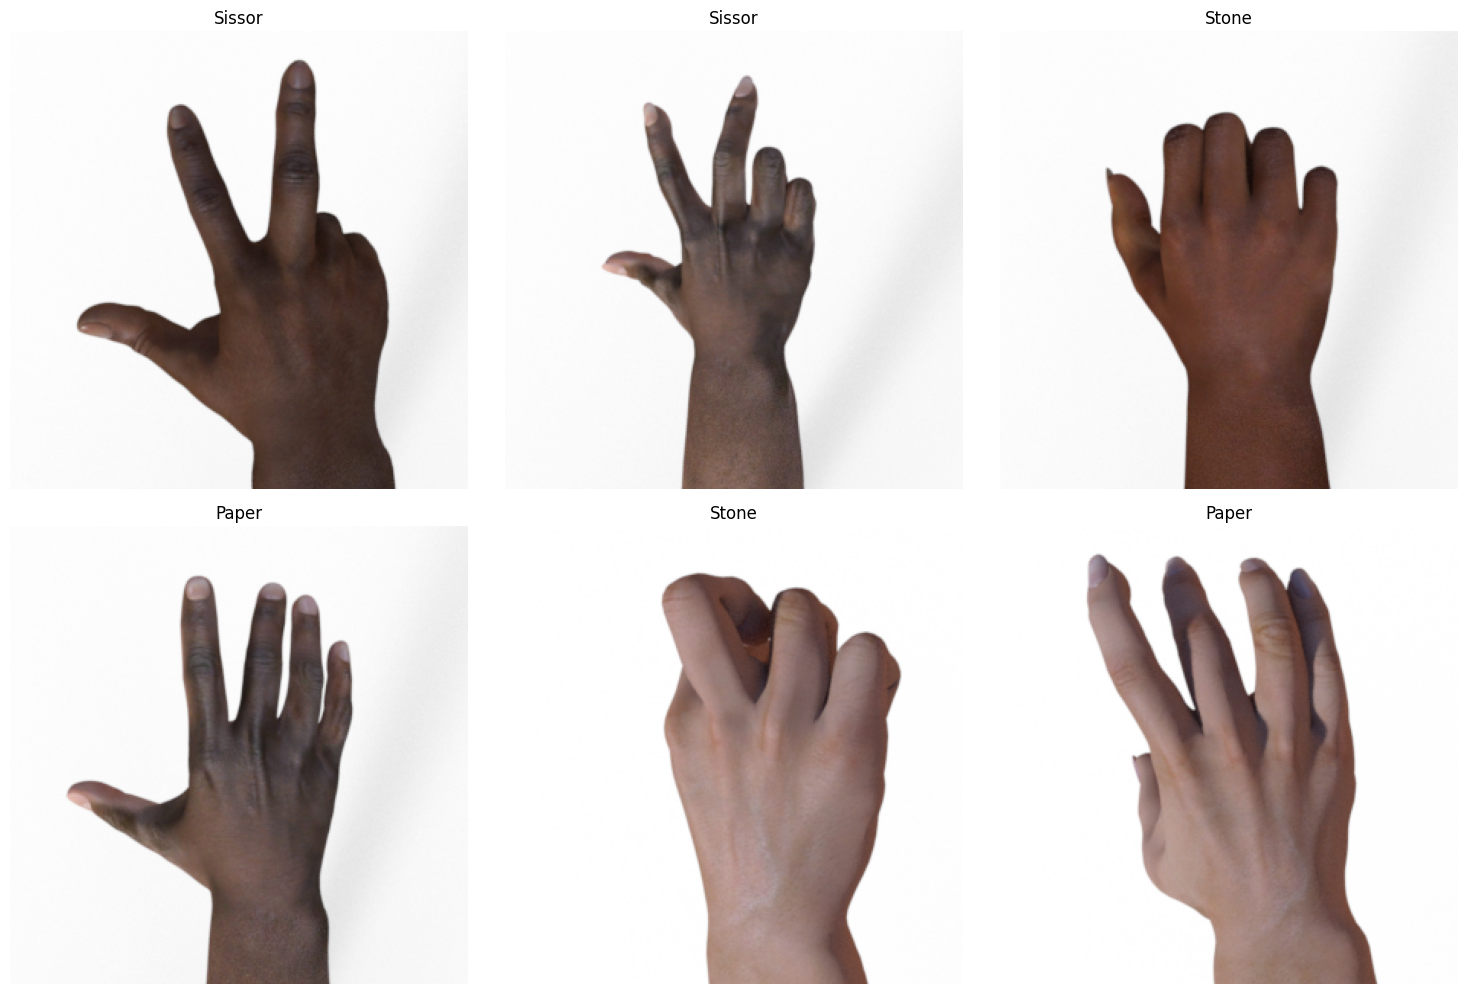

In [ ]:
# make_plot_data_training_data
for images,labels in train.take(1):break                                        # get_a_batch_of_data
images_to_plot:int=6                                                            # number of images to plot
plt.figure(figsize=(15,15))                                                     # figure size
for index in range(images_to_plot):                                             # loop over image index
  plt.subplot(3,3,index+1)                                                      # subplot rows = 3, columns = 3
  plt.imshow(images[index].numpy().astype('uint8'))                             # make plot image
  plt.axis('off')                                                               # make axis off
  plt.title(training_classes[labels[index].numpy()])                            # make add labels as class names
plt.tight_layout()                                                              # adjust layout space
plt.show()

In [ ]:
print('Maximum pixel values:',tf.reduce_max(images))                            # maximum pixel values in inputs
print('Minimum pixel values:',tf.reduce_min(images))                            # minimum pixel values in inputs
print('Object type of inputs (X):',type(images))                                # input types
print('Data type in inputs (X):',images.dtype)                                  # data type in inputs
print('Object type of outputs (y):',type(labels))                               # output types
print('Data type in outputs (X):',labels.dtype)                                 # data type in outputs

Maximum pixel values: tf.Tensor(255, shape=(), dtype=uint8)
Minimum pixel values: tf.Tensor(4, shape=(), dtype=uint8)
Object type of inputs (X): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in inputs (X): <dtype: 'uint8'>
Object type of outputs (y): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in outputs (X): <dtype: 'int64'>


In [ ]:
# make apply data augmentation to data (add more randomness to data)
# source: https://www.tensorflow.org/tutorials/images/data_augmentation
random_flip=tf.keras.layers.RandomFlip('horizontal_and_vertical',name='random_flip')# random flip layer
random_zoom=tf.keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1,name='random_zoom')# random zoom layer
random_rotate=tf.keras.layers.RandomRotation(0.3,name='random_rotate')          # random rotate layers
random_brightness=tf.keras.layers.RandomBrightness(0.3,value_range=(0.0,255.0),name='random_brightness')# random brightness layer
augmentations=[random_flip,random_zoom,random_rotate,random_brightness]         # make list of data augmentation
resizer = tf.keras.layers.Resizing(299,299,interpolation='nearest',name='rescale')
# make apply augmentation on training data
for augmentation in augmentations:
  train.map(lambda images,labels: (augmentation(images),labels))                # make apply augmentation
train=train.map(lambda images ,labels:(resizer(images),labels))
valid=valid.map(lambda images ,labels:(resizer(images),labels))
test=test.map(lambda images ,labels:(resizer(images),labels))

In [ ]:
base_model=tf.keras.applications.Xception(include_top=False,weights='imagenet',input_shape=(299,299,3))# laod base model - VGG16
#base_model.summary(line_length=120,positions=None,print_fn=None,expand_nested=True,show_trainable=False,layer_range=None)# print base model summary
base_model.trainable=False

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
inputs=tf.keras.layers.Input(shape=(299,299,3),batch_size=None,name='model_inputs')# add input layer
model_x=tf.keras.layers.Rescaling(2./255.0,offset=-1.0,name='rescaler')(inputs) # rescale inputs
model_x=base_model(model_x)                                                     # feed inputs to base model
model_x=tf.keras.layers.Flatten(name='flatten')(model_x)                         # make flatten outputs
model_x=tf.keras.layers.Dense(1024,activation='relu')(model_x)                  # apply dense layer
outputs=tf.keras.layers.Dense(len(training_classes),activation='softmax')(model_x)# output layer
model=tf.keras.Model(inputs=[inputs],outputs=[outputs],name='custom_vgg16')     # build model
model.summary(line_length=120,positions=None,print_fn=None,expand_nested=True,show_trainable=True,layer_range=None)# print model summary

In [ ]:
# make compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
# make early stopping
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',min_delta=0,patience=10,verbose=1,mode='auto',restore_best_weights=True)

# make train model
history=model.fit(train,batch_size=128,epochs=10_000,verbose=2,callbacks=[early_stop],validation_split=0,validation_data=valid,
                  shuffle=True)

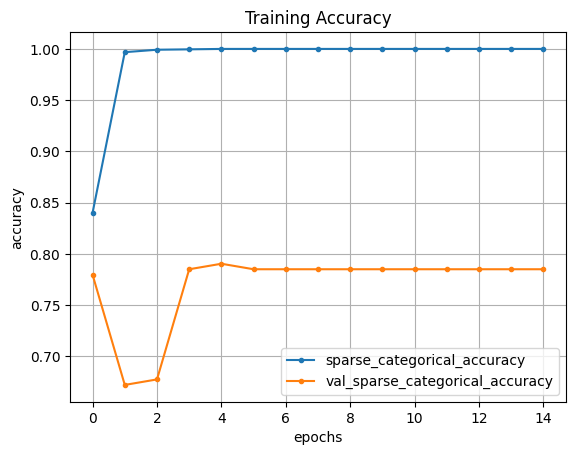

In [ ]:
# make plot training accuracy and validation accuracy
pd.DataFrame(history.history)[['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot(marker='.')# make plot
plt.grid(),plt.title('Training Accuracy'),plt.xlabel('epochs'),plt.ylabel('accuracy')# add grid, title and axis labels
plt.show()                                                                      # make plot show

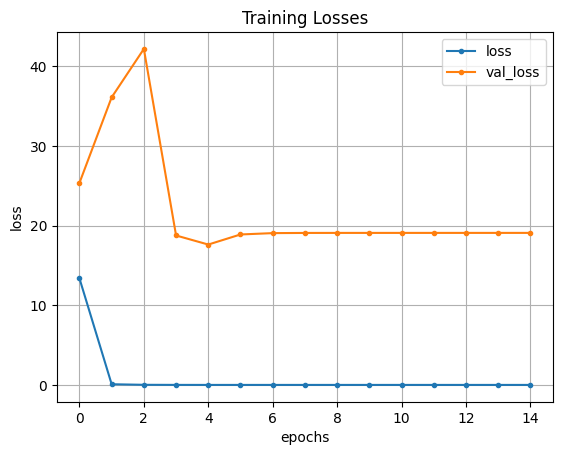

In [ ]:
# make plot training losses and validation losses
pd.DataFrame(history.history)[['loss','val_loss']].plot(marker='.')             # make plot
plt.grid(),plt.title('Training Losses'),plt.xlabel('epochs'),plt.ylabel('loss') # add grid, title and axis labels
plt.show()                                                                      # make plot show

In [ ]:
# evaluate model
results=model.evaluate(test,batch_size=None,verbose="auto",sample_weight=None,return_dict=True)
print('Testing results:',results)                                               # make print results

2/2 [==============================] - 2s 436ms/step - loss: 17.6286 - sparse_categorical_accuracy: 0.7903
Testing results: {'loss': 17.628644943237305, 'sparse_categorical_accuracy': 0.7903226017951965}


In [ ]:
# make save model (weights and configuration)
model.save('rps',overwrite=True,save_format=None)               # make save

In [ ]:
!zip -r -qq "rps.zip" "rps"                     # make zip model
# make auto download model weights
from google.colab import files                                                  # load file class
files.download('rps.zip')                                       # download model zip file



zip error: Interrupted (aborting)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>